### Однофакторный дисперсионный анализ (ANOVA)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import itertools
import scipy
import tqdm
from scipy import stats
import random

from IPython.display import *

Сгенерируем теоретическую генеральную совокупность.

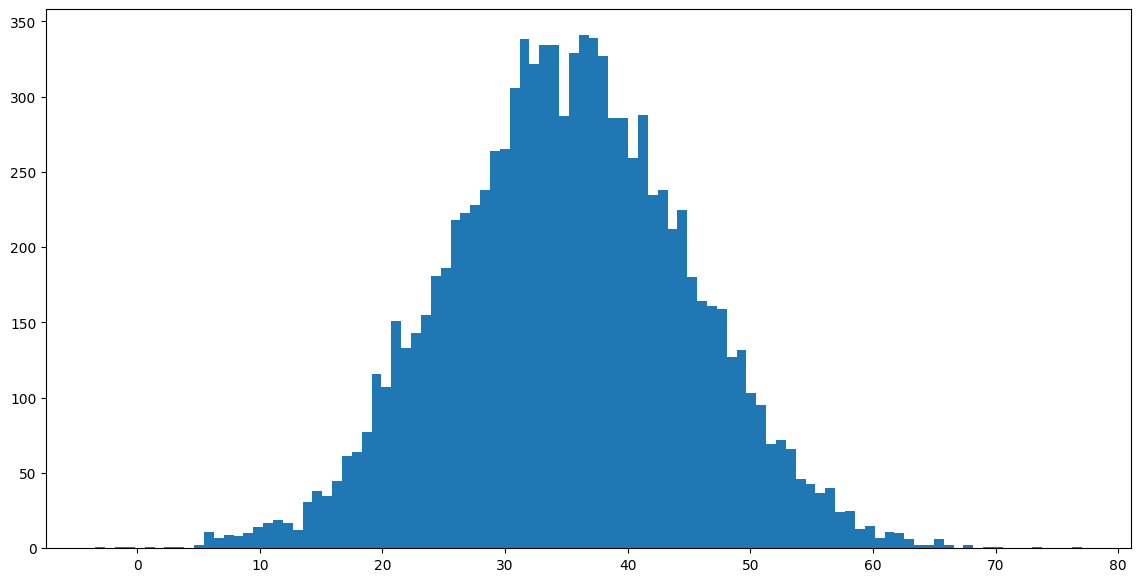

In [2]:
distrib = stats.norm(loc = 35, scale = 10)
gen_pop = distrib.rvs(size=10000)

fig = plt.figure(figsize=(14, 7))
ax1 = plt.subplot(111)
plt.hist(gen_pop, 100)
plt.show()

Извлечем из нашей совокупности 3 случайные подгруппы по 50 заказов в каждой - пусть это будут наблюдения, полученные в реальном эксперименте.

In [3]:
np.random.seed(3106)
sample_groups = []
for i in range(3):
    sample_groups.append(np.random.choice(gen_pop, size = 50).astype(int))
sample_groups = np.array(sample_groups)
sample_groups

array([[38, 44, 43, 36, 33, 39, 26, 24, 21, 32, 29, 38, 29, 46, 33, 37,
        40, 45, 41, 33, 30, 31, 30, 58, 22, 29, 45, 38, 53, 35, 44, 26,
        42, 45, 32, 31, 39, 38, 28, 50, 27, 46, 25, 26, 43, 43, 26, 39,
        34, 43],
       [18, 29, 41, 26, 41, 26, 31, 56, 53, 50, 38, 43, 48, 33, 40, 46,
        22, 41, 43, 42, 46, 29, 27, 42, 37, 24, 19, 50, 33, 39, 13, 34,
        44, 33, 37, 21, 48, 18, 43, 30, 30, 31, 21, 27, 27, 22, 24, 32,
        32, 32],
       [13, 29, 39,  5, 59, 40, 25, 46, 41, 32, 36, 36, 58, 42, 21, 47,
        49, 43, 38, 31, 28, 34, 35, 33, 19, 22, 39, 57, 36, 27, 16, 24,
        40, 31, 48, 31, 41, 38, 49, 44, 41, 30, 43, 31, 37, 56, 46, 45,
        31, 48]])

Рассчитаем:
- среднее каждой выборки и стандартное отклонение (голубые линии на графике)
- среднее средних и стандартное отклонение средних (оранжевая линия на графике)

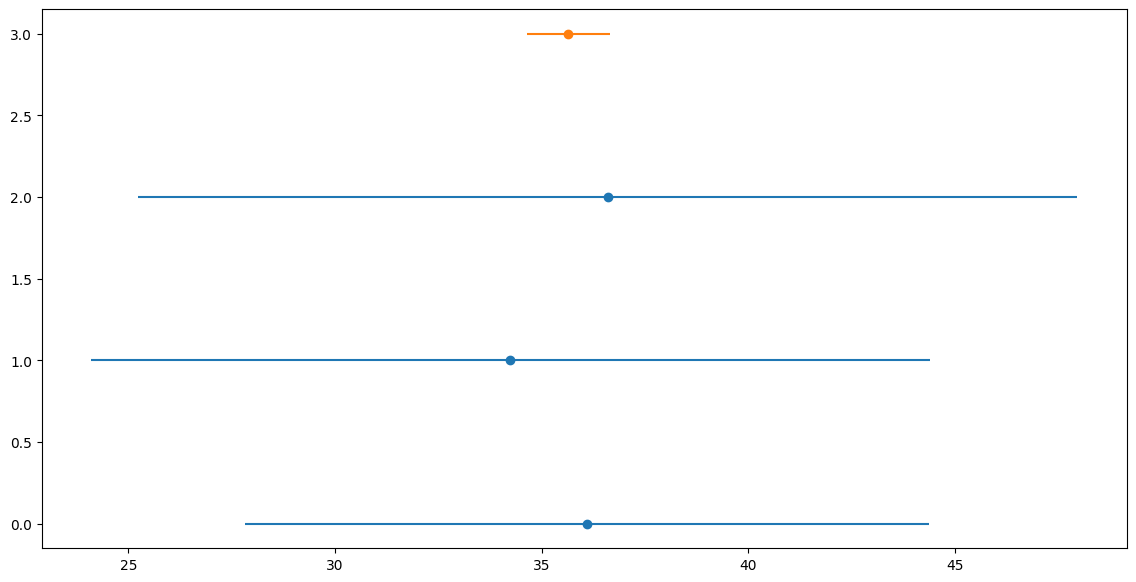

In [4]:
x = np.mean(sample_groups,axis = 1)
y = np.arange(sample_groups.shape[0])
e = np.std(sample_groups,axis = 1)

fig = plt.figure(figsize=(14, 7))
plt.errorbar(x, y, xerr = e, linestyle='None', marker='o')
plt.errorbar( np.mean(x), y.shape[0] ,xerr =  np.std(x), linestyle='None', marker='o')

plt.show()

**1)	формулируются гипотезы Н0 и Н1;**


H0 - выборки взяты из одного распределения (средние всех выборок равны)

H1 - выборки взяты из разных распределений (хотя бы пара средних различается между собой)

**2)	фиксируется уровень значимости критерия значимости**

Зададим α на уровне значимости 5%.

**3)выбирается статистический критерий для проверки гипотезы;**

Будем использовать ANOVA.

**4) по выборочным данным вычисляется значение K-наблюдаемое по распределению выбранной статистики**

In [5]:
num_of_groups = sample_groups.shape[0]

In [6]:
#Рассчитаем среднее по всем наблюдениям:
X_mean = sample_groups.mean()
X_mean

35.64666666666667

In [7]:
# Рассчитаем среднее для каждой группы
group_means = sample_groups.mean(axis = 1)
group_means_reshaped = group_means.reshape(num_of_groups, 1)

In [8]:
# SSW
SSW  = np.sum((sample_groups  - group_means_reshaped)**2)
SSW

15007.62

In [9]:
# SSB
group_lengths = [x.shape[0] for x in sample_groups]

SSB  = np.sum((group_means - X_mean)**2 * group_lengths)
SSB

154.65333333333325

In [10]:
# F
m = num_of_groups
N = np.sum(group_lengths)

F = (SSB/(m-1))/(SSW/(N-m))
F

0.7574165657179481

Воспользуемся пакетом stats для аналогичного расчета:

In [11]:
F, p = stats.f_oneway(*sample_groups)

In [12]:
# F-наблюдаемое
F

0.7574165657179487

**5)	с учетом выбранного уровня значимости вычисляется критическая область и область принятия гипотезы, то есть находится K-критическое**

In [13]:
# F-критическое
F_critical = scipy.stats.f.ppf(q=1-.05, dfn = m, dfd = N - m)
F_critical

2.6661487758521765

**6)	найденное значение K-наблюдаемое критерия сравнивается с K-критическое и по результатам сравнения делается вывод**

In [14]:
F < F_critical

True

**Вывод**: Мы не можем отвергнуть гипотезу H0

In [15]:
p

0.47069705516793214

In [16]:
p > 0.05

True

Теперь давайте попробуем разобраться, откуда взялось распределение F, с которым мы работали.

Будем из нашей генеральной совокупности извлекать выборки и считать F. Выборки будут также размером 50 и количество выборок будет равно 3, то есть по аналогии с тем же дизайном эксперимента, который мы проводили выше.

In [20]:
def calculate_random_sample_group(sz = 50):
    sample_groups = []
    for i in range(num_of_groups):
        sample_groups.append(np.random.choice(gen_pop,  size = sz))
    F, _ = stats.f_oneway(*sample_groups)    
    return sample_groups, F

Fs = []
sgs = []
for i in tqdm.tqdm(range(10000)):
    sg,F = calculate_random_sample_group()
    Fs.append(F)
    sgs.append(sg)

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 15599.29it/s]


Распределение приняло опредленную форму, такое распредление называется распредление Фишера, на основе рассчитанных статистик по нему мы как раз и принимали решения.

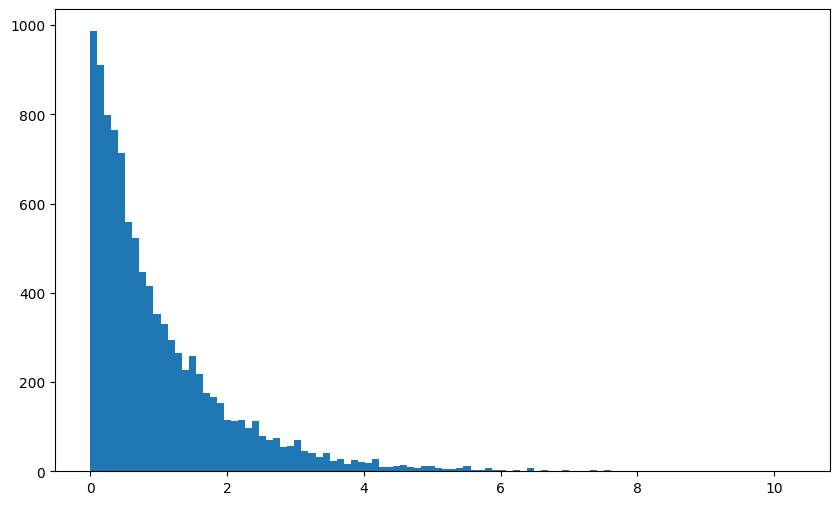

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(Fs,bins = 100)
plt.show()